# Visualization: New York Stock Exchange

In this note, I would try to visualize some metrics of stocks in NYSE. The datasets are about S&P 500 companies historical prices with fundamental data and come from [Kaggle-dataset-NYSE](https://www.kaggle.com/dgawlik/nyse), which contain four .csv files, "fundamentals.csv", "securities.csv" and "prices-split-adjusted.csv" and "prices.csv". And I will use first three ones.

In [1]:
% matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.finance import candlestick_ochl
from matplotlib.dates import date2num, MonthLocator, WeekdayLocator, DateFormatter, MONDAY
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from datetime import datetime
import seaborn as sns

In [2]:
fund=pd.read_csv('E:/PRO/stock/fundamentals.csv', header=0, 
                 usecols=list(range(1,79)),parse_dates=[2])
date=pd.to_datetime(fund['Period Ending'],format='%Y-%m-%d')
Year=np.array([i.year for i in date])
fund['Year']=Year
fund=fund[['Ticker Symbol', 'Year','Earnings Per Share','Profit Margin',
           'After Tax ROE','Gross Profit','Total Revenue']]   #1781*8

securities=pd.read_csv('E:/PRO/stock/securities.csv', header=0)
security=securities[['Ticker symbol', 'GICS Sector', 'GICS Sub Industry']]

## Preprocessing
For fundamental data, let's try to observe earning per share, profit margin, gross profit, total revenue and after tax ROE of each GICS Sector or its sub industry.   
First, we merge fundamental data with securities information to link GICS sector information to every stock. By check the missing value, here we remove stocks which have NA values in earning per share.

In [3]:
fundamental=pd.merge(fund,security, left_on="Ticker Symbol",right_on="Ticker symbol")
fundamental=fundamental.drop('Ticker symbol',axis=1)   #remove overlap col, now its shape is 1781*9

print('NAs of Gorss Profit:',fundamental["Gross Profit"].isnull().sum())
print('NAs of Total Revenue:',fundamental["Total Revenue"].isnull().sum())
print('NAs of Earnings/Share:',fundamental["Earnings Per Share"].isnull().sum())

fundamental=fundamental[fundamental["Earnings Per Share"].isnull() != True]  #drop na of Earnings per share
 # Now its shape is 1562 × 9

NAs of Gorss Profit: 0
NAs of Total Revenue: 0
NAs of Earnings/Share: 219


## Scatter Plot
There are 11 major industry in GICS sector. Here we have an overall look of every company's earning per share and profit margin in 2014 with different color mark of their industries.   
You can easily find there are some outliers in the these industries. That may suggest positive or negative influence on choice of investment portfolio in long-term.   
Note: There are some outliers so far away from major part of other points that cannot show them in the figure with the range limit of x/y axes *for beauty*. **In practical analysis, it is dangerous if you limit the range of axes at first, as you may ignore some outliers.**

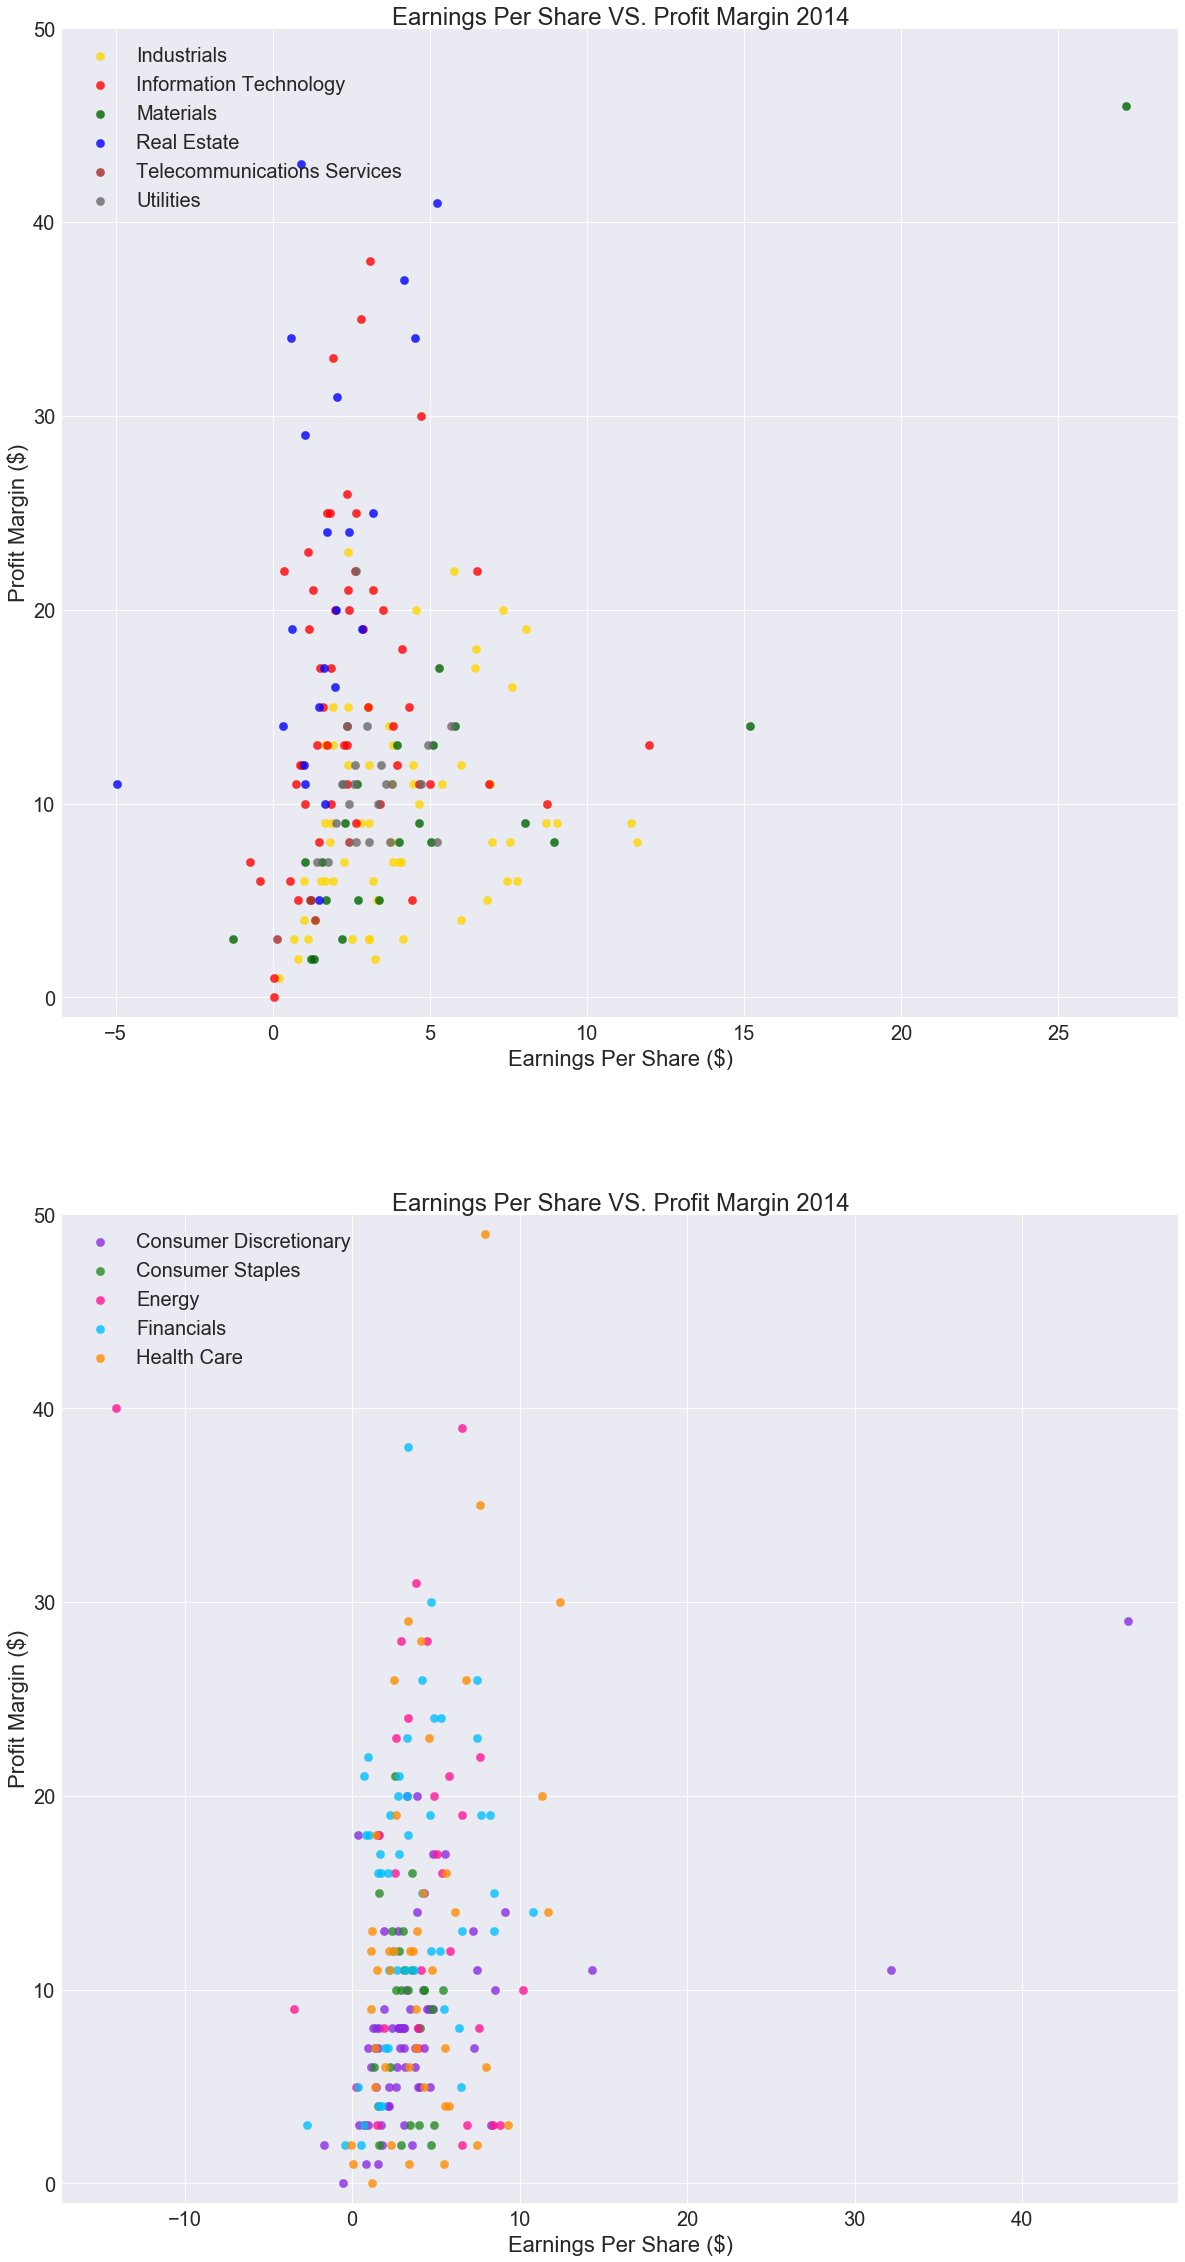

In [4]:
mycolor=['blueviolet','forestgreen','deeppink','deepskyblue','darkorange',
         'gold','r','darkgreen','b','brown','dimgrey']
flag=0
yr=2014
sns.set(font_scale=2.0)
fig, (ax1, ax2)=plt.subplots(2, 1, figsize=(20,40))
for i in fundamental.groupby(['GICS Sector']).groups.keys():
    if flag>=5:
        ax1.scatter(fundamental[(fundamental["GICS Sector"]==i)&(fundamental["Year"]==yr)]['Earnings Per Share'],
                   fundamental[(fundamental["GICS Sector"]==i)&(fundamental["Year"]==yr)]['Profit Margin'],
                   color=mycolor[flag],alpha=0.8,label=i,s=70.0)
    else:
        ax2.scatter(fundamental[(fundamental["GICS Sector"]==i)&(fundamental["Year"]==yr)]['Earnings Per Share'],
                   fundamental[(fundamental["GICS Sector"]==i)&(fundamental["Year"]==yr)]['Profit Margin'],
                   color=mycolor[flag],alpha=0.8,label=i,s=70.0)
    flag=flag+1
#ax1.set_xlim(-3, 10)
ax1.set_ylim(-1, 50)
ax1.set_xlabel('Earnings Per Share ($)')
ax1.set_ylabel('Profit Margin ($)')
ax1.set_title('Earnings Per Share VS. Profit Margin {}'.format(yr))
ax1.legend(loc=2)
#ax2.set_xlim(-5, 10)
ax2.set_ylim(-1, 50)
ax2.set_xlabel('Earnings Per Share ($)')
ax2.set_ylabel('Profit Margin ($)')
ax2.set_title('Earnings Per Share VS. Profit Margin {}'.format(yr))
ax2.legend(loc=2)

plt.show()

## Bar and Line Chart
In this part, we describe the trend of after tax ROE and gross profit from 2013 to 2015 of companies in the GICS sub industry--airlines. They are Alaska Air Group Inc, American Airlines Group, Delta Air Lines, Southwest Airlines and United Continental Holdings.     
We combine bar chart and line chart in the same figure.   
For company which have a sharp rise in gross profit, you may dig more details about its changes in business and corporate strategy or top management team for reasons behind this situation.

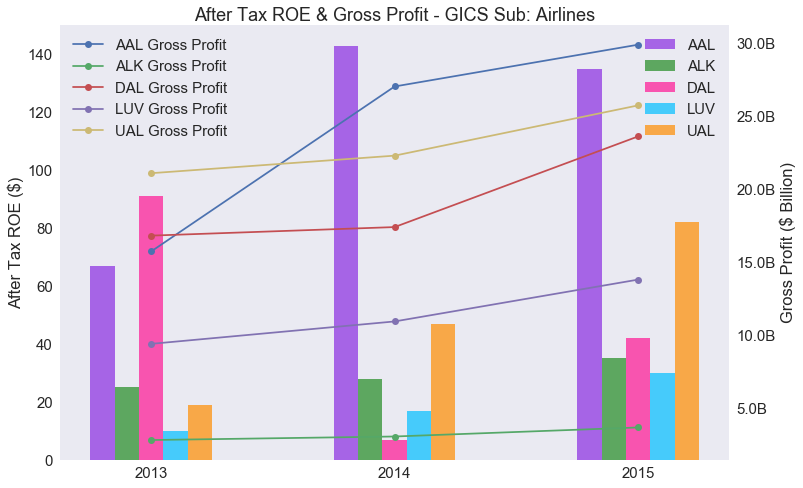

In [5]:
mycolor2=['blueviolet','forestgreen','deeppink','deepskyblue','darkorange']
airlines=fundamental.groupby(['GICS Sub Industry']).get_group("Airlines")
ticker=sorted(list(set(airlines['Ticker Symbol'])))
year=[2013,2014,2015]
gp=[0]*len(ticker)
ind=np.arange(len(year))
width=0.1
sns.set(font_scale=1.5)
sns.set_style("dark")
fig, ax1 = plt.subplots(figsize=(12,8))
ax2=ax1.twinx()

def billions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fB' % (x*1e-9)

formatter = FuncFormatter(billions)


for i in range(len(ticker)):
    roe=airlines[(airlines['Ticker Symbol']==ticker[i])&(airlines['Year']>=year[0])&(airlines['Year']<=year[-1])]['After Tax ROE']
    gp[i]=airlines[(airlines['Ticker Symbol']==ticker[i])&(airlines['Year']>=year[0])&(airlines['Year']<=year[-1])]['Gross Profit']
    ax1.bar(ind+i*width,roe,width,color=mycolor2[i],label=ticker[i],alpha=0.7)
    ax2.plot(ind+ width*2,gp[i],'-o',label=ticker[i]+" Gross Profit")
    #break
ax1.set_ylabel('After Tax ROE ($)')
ax1.set_title('After Tax ROE & Gross Profit - GICS Sub: Airlines')
ax1.set_xticks(ind + width*2)
ax1.set_xticklabels(year)
ax2.set_ylabel('Gross Profit ($ Billion)')
ax2.yaxis.set_major_formatter(formatter)

ax1.legend()
ax2.legend(loc=2)
plt.show()


## Pie Chart
To have a look on the scale of total revenue of every sector, let's use pie chart to show their relative size. Note when comment on the prospect of a industry, number of companies is also an important factor of its balance between supply and demand.

In [6]:
fundamental2=fundamental[fundamental['Year']==2015]
fundamental2.groupby(["GICS Sector"])["Total Revenue"].sum()

GICS Sector
Consumer Discretionary         1.366729e+12
Consumer Staples               1.362299e+12
Energy                         8.586695e+11
Financials                     8.514188e+11
Health Care                    1.195072e+12
Industrials                    1.004969e+12
Information Technology         8.437562e+11
Materials                      2.678456e+11
Real Estate                    7.378732e+10
Telecommunications Services    3.101260e+11
Utilities                      2.250157e+11
Name: Total Revenue, dtype: float64

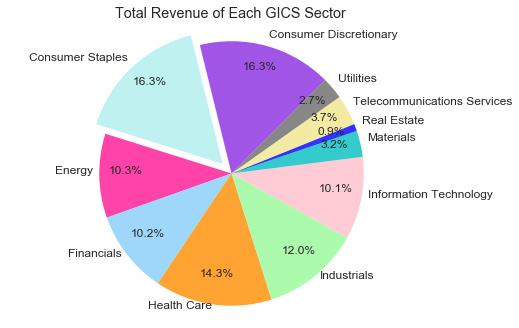

In [7]:
mycolor=['blueviolet','paleturquoise','deeppink','lightskyblue','darkorange',
         'palegreen','pink','c','b','khaki','dimgrey']
TR=fundamental2.groupby(["GICS Sector"])["Total Revenue"].sum().values
TR_label=fundamental2.groupby(["GICS Sector"])["Total Revenue"].sum().index.values
explodes=[0]*len(TR)
explodes[1]=0.1
fig, ax = plt.subplots()
sns.set(font_scale=1.2)
ax.pie(TR, labels=TR_label,explode=explodes,labeldistance=1.05,
       textprops={'fontsize':12,'va':'bottom'},pctdistance=0.8, colors=mycolor,
       autopct='%1.1f%%', shadow=False, startangle=45,radius=1,wedgeprops={'joinstyle':'miter','alpha':0.8})
ax.set_title("Total Revenue of Each GICS Sector")
ax.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

## Candlestick
For last chart, we focus on single stock, here I choose Amazon("AMZN"). I use candlestick to show its stock price trend during the first half of the year 2016. Although we could export this kind of figures easily from Bloomberg or Morning Star Direct, this show the versatility of matplotlib.

In [8]:
price=pd.read_csv('E:/PRO/stock/prices-split-adjusted.csv', header=0)
#price['date']=pd.to_datetime(price['date'],format='%Y-%m-%d')
amzn=price[price['symbol']=='AMZN']
amzn=price[(price['symbol']=='AMZN')&(price['date']>='2016-01-01')&(price['date']<'2016-07-01')]
amzn=amzn.drop('symbol',axis=1)  #now its shape is 252*6
amzn.head()

,date,open,close,low,high,volume
725425,2016-01-04,656.289978,636.989990,627.510010,657.719971,9314500.0
725924,2016-01-05,646.859985,633.789978,627.650024,646.909973,5822600.0
726423,2016-01-06,622.000000,632.650024,620.309998,639.789978,5329200.0
726922,2016-01-07,621.799988,607.940002,605.210022,630.000000,7074900.0
727421,2016-01-08,619.659973,607.049988,606.000000,624.140015,5512900.0


In [9]:
#notice that candlestick_ochl needs specific order of [open, close, high, low]
amzn['low'],amzn['high']=amzn['high'],amzn['low']   #exchange high and low
priceamzn=[]
for i in range(0,len(amzn)):    #convert dataframe to tuple as candlestick_ochl needs
    temp=[]
    DD=date2num(datetime.strptime(amzn.iloc[i][0], "%Y-%m-%d"))  #change the format of date
    temp.append(DD)
    temp.extend(list(amzn.iloc[i][1:]))
    priceamzn.append(tuple(temp))

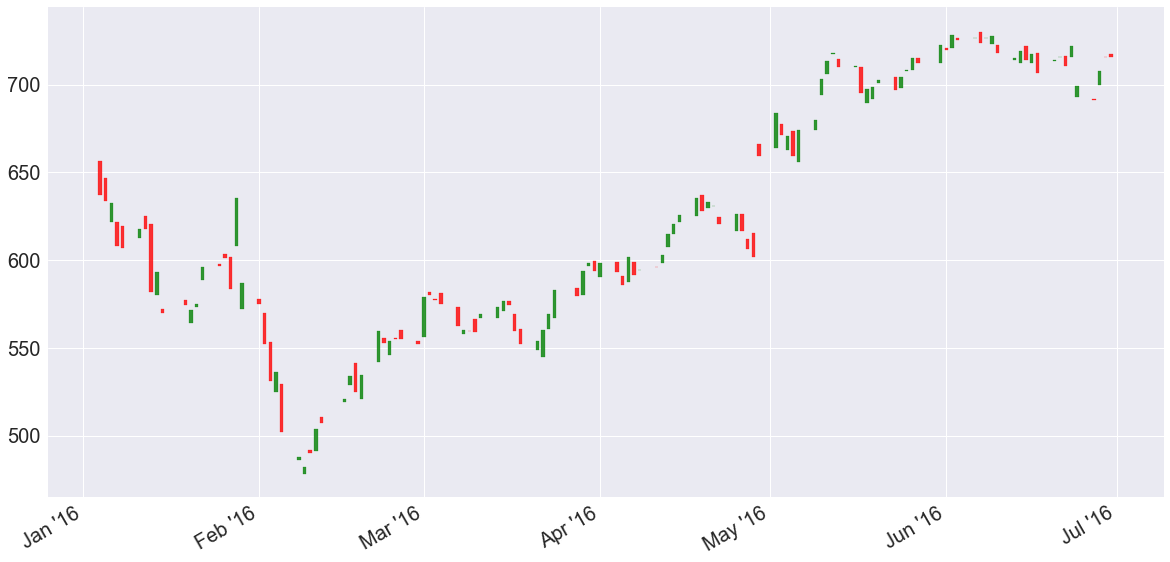

In [10]:
mondays = WeekdayLocator(MONDAY)   #minor ticks on mondays if need
months = MonthLocator(range(1, 13), bymonthday=1, interval=1)    #major ticks on month
monthsFmt = DateFormatter("%b '%y")
sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(20,10))
candlestick_ochl(ax, priceamzn, width=0.6,alpha=0.8,colorup='g', colordown='r')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
#ax.xaxis.set_minor_locator(minorLocator)
ax.autoscale_view()
fig.autofmt_xdate()
ax.xaxis_date()
plt.show()

---------------------
<center>May 22 2017</center>
<center>Ysabelle ♥ Arbor Luxuriance</center>